# Tensor Flow 入門

## 初心者のための TensorFlow 2.0 入門
- [初心者のための TensorFlow 2.0 入門](https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ja)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

画像データの読み込み
- 訓練用の入力となる28x28ピクセルの画像が60000枚、その答えが60000件
- テスト用の入力となる28x28ピクセルの画像が10000枚、その答えが10000件

In [27]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

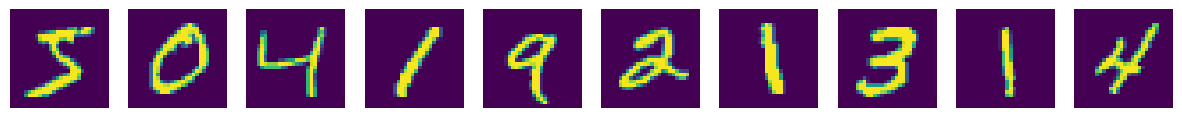

In [28]:
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i])
    plt.axis(False)
plt.show()

画像のピクセル値は 0～255 です。値を 255.0 で割って、0～1 の範囲に変換し、計算しやすくする

In [29]:
print(x_train[0].min(), x_train[0].max())
x_train, x_test = x_train / 255, x_test / 255
print(x_train[0].min(), x_train[0].max())

0 255
0.0 1.0


機械学習モデルの構築
- Sequential 複数のレイヤーを扱う
- Flatten 画像データを一次元に変換
  - 28x28 = 784
- Dense 128のweightを持つ隠れ層に、活性化関数 relu を使用し、バイアスを加える
  - 784 x 128(weight) + 128(bias)
- Dropout
  - 得られたモデルの重みに 0.2 をかけたものを推論時に使用
- Dense 10のノードを持つ層で、10個の値を出力
  - 128 x 10 + 10

In [30]:
# 機械学習モデルの構築
model = tf.keras.models.Sequential([
    # インプットデータのサイズ
    tf.keras.Input(shape=(28, 28, 1), name='input'),
    # 28x28の元データを784の縦ベクトルに変換
    tf.keras.layers.Flatten(name='flatten'),
    # 784x128の行列に変換
    tf.keras.layers.Dense(128, activation="relu", name='Dense1'),
    # レイヤーから出力された特徴量に対してランダムにゼロ化する割合を指定
    tf.keras.layers.Dropout(0.2, name='dropout'),
    # 128x10の行列に変換
    tf.keras.layers.Dense(10, name='Dense2'),
    ])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

学習前のモデルでデータを入れて確認する
- 10個の値が出力され、それぞれ予測した値を示している
- 学習前なので適当な値になっている
- さらにソフトマックス関数を適用、確率で表している(マイナスをなくしている)
- 違いを視覚化すると、0以上になっていることがわかる

tf.Tensor(
[[-0.5842793   0.0794629   0.5503582   0.54362977  0.00393077 -0.09468023
  -0.23169047  0.02147379  0.5816321  -0.2904391 ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.04906891 0.0952941  0.15260658 0.15158322 0.08836145 0.08006387
  0.0698126  0.08992524 0.1574546  0.06582936]], shape=(1, 10), dtype=float32)


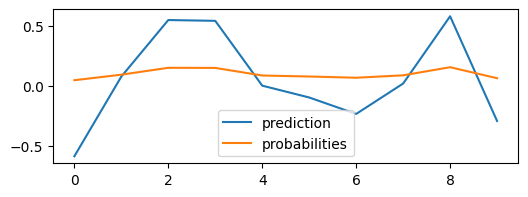

In [31]:
prediction = model(x_train[:1])
print(prediction)

probabilities = tf.nn.softmax(prediction)
print(probabilities)


plt.figure(figsize=(6, 2))
plt.plot(prediction.numpy()[0], label='prediction')
plt.plot(probabilities.numpy()[0], label='probabilities')
plt.legend()
plt.show()

損失関数の計算と定義
- 訓練データの一つ目は 5 を表す画像になっている
- その確率は 0.12061442 となっており、その値の対数により表す
- SparseCategoricalCrossentropy()
  - 疎なカテゴリーのクロスエントロピー関数を意味する
- 手計算と SparseCategoricalCrossentropy() が同じになることを確認

In [32]:
# 損失関数の計算 手計算で確認
answer = probabilities[0][5]
print(tf.math.log(answer))

# 損失関数の定義(上の数値と一致する)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
print(loss_fn(y_train[:1], prediction).numpy())

tf.Tensor(-2.5249305, shape=(), dtype=float32)
2.5249305


モデルの構成とコンパイル(実行可能な形態を構築する変換)
- model.compile 学習時に使う手法を設定する
  - optimizer='adam' 最適化手法
  - loss=loss_fn 損失関数
  - metrics=['accuracy'] 評価指数

In [33]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

モデルをトレーニングして評価
- ノードの値を重みの値をパラメータフィットし、損失関数を最小化している
- model.fit 
  - x_train 入力データ
  - y_train 正解データ
  - epochs=5 学習の繰り返し数

In [34]:
history = model.fit(x_train, y_train, epochs=5, verbose=1)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8600 - loss: 0.4800
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9557 - loss: 0.1511
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9670 - loss: 0.1073
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9724 - loss: 0.0887
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9780 - loss: 0.0686


テストデータによる確認
- model.evaluate
  - x_test, y_test テストデータ
  - verbose=0 logなし, verbose=1, logあり, verbose=2, 結果のみ
- loss 損失関数値
- accuracy 正解率

In [35]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'テストデータによる正解率 : {accuracy:.02%}')

テストデータによる正解率 : 97.51%


モデルが確率を返すようにソフトマックス関数を Sequential に追加
- Softmax() ソフトマックス関数
- probaility_model 新たに作成したモデルにテストデータを入れる
- predict_result 確率に変換した結果
- np.argmax 最大値のインデックス(位置)を出力 → 7 と予想したことになる

In [36]:
# モデルが確率を返すようにソフトマックス関数を設定
probaility_model = tf.keras.Sequential([model, tf.keras.layers.Softmax(),])
predict_result = probaility_model(x_test)
print(np.argmax(predict_result[0]))

7


テストデータによる予測した値と正解の値の比較
- 30個 目視で確認
- すべてのテストデータで間違えた割合を確認

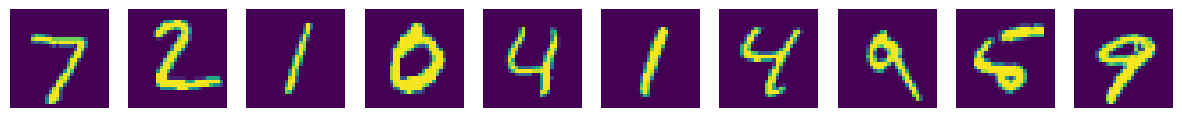

In [37]:
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i])
    plt.axis(False)
plt.show()

In [38]:
# 正解と予測結果の表示
display_num = 10
predict_result = probaility_model(x_test)
print('正解', end=', ')
for i, y in enumerate(y_test[:display_num]):
    print(y, end=', ')
print()
print('予測', end=', ')
for i, p in enumerate(predict_result[:display_num]):
    print(np.argmax(p), end=', ')
print()

# 正解割合の表示
count = 0
for i, (y, p) in enumerate(zip(y_test, predict_result)):
    if y != np.argmax(p):
        count += 1
print(f'正解割合 : {1 - count / len(y_test):.02%}')

正解, 7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 
予測, 7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 
正解割合 : 97.51%


Epoch ごとの正解率と損失関数の推移
- history.history 履歴が残っている
- 繰り返しごとに損失関数が低下し、正解率が上がっている

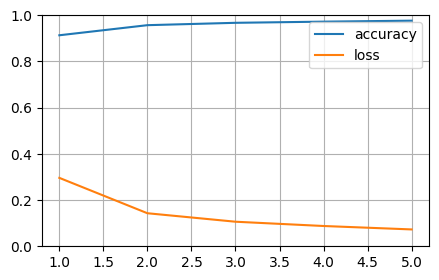

In [39]:
df = pd.DataFrame(history.history)
df.index = [i+1 for i in range(5)]
df.plot(figsize=(5, 3))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## エキスパートのための MNIST

In [17]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.17.0


In [18]:
# read dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape, x_test.shape)

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [19]:
# データセットをバッチ化してシャッフル
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [49]:
for t in train_ds:
    print(t[1].numpy())
    break

[3 0 0 0 7 1 9 0 8 7 5 6 9 4 9 8 7 2 9 6 6 8 6 2 7 0 1 4 6 1 8 5]


In [41]:
class MyModel(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)
    
model = MyModel()

In [21]:
# 損失関数とオプティマイザー
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [22]:
# モデルの損失と精度を測定するためのメトリクス
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acuracy')

In [42]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [24]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [25]:
EPOCHS = 5

for epoch in range(EPOCHS):

    train_loss.reset_state()
    train_accuracy.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
        f"Epoch {epoch + 1}, "
        f"Loss: {train_loss.result():.05f}, "
        f"Accuracy: {train_accuracy.result():.03%}, "
        f"Test Loss: {test_loss.result():.05f}, "
        f"Test Accuracy: {test_accuracy.result():.03%}"
    )

Epoch 1, Loss: 0.14072875678539276, Accuracy: 0.958, Test Loss: 0.06888289004564285, Test Accuracy: 0.978
Epoch 2, Loss: 0.044606782495975494, Accuracy: 0.986, Test Loss: 0.0646989718079567, Test Accuracy: 0.979
Epoch 3, Loss: 0.025567293167114258, Accuracy: 0.992, Test Loss: 0.05101698264479637, Test Accuracy: 0.984
Epoch 4, Loss: 0.013960277661681175, Accuracy: 0.996, Test Loss: 0.055056147277355194, Test Accuracy: 0.986
Epoch 5, Loss: 0.010817072354257107, Accuracy: 0.997, Test Loss: 0.07170972228050232, Test Accuracy: 0.982


## 畳み込みニューラルネットワークで mnist を学習する

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

model = keras.models.Sequential()
model.add(keras.Input(shape=(28, 28, 1)))
model.add(keras.layers.Rescaling(1./255))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10))

model.summary()

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=5, verbose=1, validation_data=(x_test, y_test))

plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.title('MNIST by CNN')
plt.savefig('../images/MNIST by CNN.jpg')
plt.legend(loc='lower right')
plt.show()

(60000, 28, 28)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.8857 - loss: 0.3583 - val_accuracy: 0.9842 - val_loss: 0.0504
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9845 - loss: 0.0523 - val_accuracy: 0.9888 - val_loss: 0.0338
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9902 - loss: 0.0334 - val_accuracy: 0.9902 - val_loss: 0.0297
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9917 - loss: 0.0262 - val_accuracy: 0.9906 - val_loss: 0.0321
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9942 - loss: 0.0201 - val_accuracy: 0.9915 - val_loss: 0.0297
313/313 - 1s - 5ms/step - accuracy: 0.9915 - loss: 0.0297
